In [94]:
# !pip install keras-tuner

# from google.colab import drive
# drive.mount('/content/drive')

# Commented out IPython magic to ensure Python compatibility.
import os
import sys
import time
import glob
import random
import argparse
import pickle
import numpy as np
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import lfilter
import scipy.signal as signal
from sklearn.utils import shuffle, compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Add, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten,
    Conv2D, DepthwiseConv2D, MaxPooling2D,
    BatchNormalization, GlobalAveragePooling2D,
    Add
)
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D,
    Dense, Dropout, Add, ReLU
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# %matplotlib inline

class DataSet2(object):

    def __init__(self, images, labels, img_names, cls):
        self._num_examples = images.shape[0]

        self._images = images
        self._labels = labels
        self._img_names = img_names
        self._cls = cls
        self._epochs_done = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def img_names(self):
        return self._img_names

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_done(self):
        return self._epochs_done

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]

def read_train_sets2(train_path, classes, validation_size):
    class DataSets(object):
        pass

    data_sets = DataSets()

    images, labels, img_names, cls = load_train2(train_path, classes)  # 2 calculating, 3 loading
    images, labels, img_names, cls = shuffle(images, labels, img_names, cls)

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])

    validation_images = images[:validation_size]
    validation_labels = labels[:validation_size]
    validation_img_names = img_names[:validation_size]
    validation_cls = cls[:validation_size]

    train_images = images[validation_size:]
    train_labels = labels[validation_size:]
    train_img_names = img_names[validation_size:]
    train_cls = cls[validation_size:]
#     print('Training dataset shape:',len (train_images))
    data_sets.train = DataSet2(train_images, train_labels, train_img_names, train_cls)
    data_sets.valid = DataSet2(validation_images, validation_labels, validation_img_names, validation_cls)

    return data_sets

def load_train2(train_path, classes):
    samples = []
    labels = []
    sample_names = []
    cls = []

    for fields in classes:
        index = classes.index(fields)
        path = os.path.join(train_path, fields, '*.npy')
        files = glob.glob(path)
        for fl in files:
            iq_samples = np.load(fl)
            real = np.real(iq_samples)
            imag = np.imag(iq_samples)

            iq_samples = np.ravel(np.column_stack((real, imag)))

            multiple = False
            if multiple:
                iq_samples1 = iq_samples[:1568]
                iq_samples1 = iq_samples1.reshape(28, 28, 2)
                iq_samples2 = iq_samples[1568:3136]
                iq_samples2 = iq_samples2.reshape(28, 28, 2)
                iq_samples3 = iq_samples[3136:4704]
                iq_samples3 = iq_samples3.reshape(28, 28, 2)
                iq_samples4 = iq_samples[4704:6272]
                iq_samples4 = iq_samples4.reshape(28, 28, 2)
                samples.append(iq_samples1)
                samples.append(iq_samples2)
                samples.append(iq_samples3)
                samples.append(iq_samples4)

                flbase = os.path.basename(fl)
                label = np.zeros(len(classes))
                label[index] = 1.0

                labels.append(label)
                labels.append(label)
                labels.append(label)
                labels.append(label)
                sample_names.append(flbase)
                sample_names.append(flbase)
                sample_names.append(flbase)
                sample_names.append(flbase)
                cls.append(fields)
                cls.append(fields)
                cls.append(fields)
                cls.append(fields)
            else:
                iq_samples = iq_samples[:1568]
                iq_samples = iq_samples.reshape(28, 28, 2)
                samples.append(iq_samples)

                label = np.zeros(len(classes))
                label[index] = 1.0
                labels.append(label)
                flbase = os.path.basename(fl)
                sample_names.append(flbase)
                cls.append(fields)

    samples = np.array(samples)
    labels = np.array(labels)
    sample_names = np.array(sample_names)
    cls = np.array(cls)
    return samples, labels, sample_names, cls

# Function to read the samples from _prediction_samples.dat files

def read_samples_sdr(freq):
    sdr = RtlSdr()
    sdr.sample_rate = sample_rate
    sdr.err_ppm = 56   # change it to yours
    sdr.gain = 'auto'

    f_offset = 250000  # shifted tune to avoid DC
    sdr.center_freq = freq - f_offset
    time.sleep(0.06)
    iq_samples = sdr.read_samples(1221376)
    iq_samples = iq_samples[0:600000]
    fc1 = np.exp(-1.0j * 2.0 * np.pi * f_offset / sample_rate * np.arange(len(iq_samples)))  # shift down 250kHz
    iq_samples = iq_samples * fc1
    return iq_samples


def read_samples(freq):
    f_offset = 250000  # Shifted tune to avoid DC
    samp = np.fromfile(str(freq)+'_prediction_samples.dat',np.uint8)+np.int8(-127) # Adding a signed int8 to an unsigned one results in an int16 array
    x1 = samp[::2]/128 # Even samples are real(In-phase)
    x2 = samp[1::2]/128 # Odd samples are imaginary(Quadrature-phase)
    iq_samples = x1+x2*1j # Create the complex data samples
    iq_samples = iq_samples[0:600000]
    fc1 = np.exp(-1.0j * 2.0 * np.pi * f_offset / sample_rate * np.arange(len(iq_samples)))  # Shift down 250kHz
    iq_samples = iq_samples * fc1
    return iq_samples

########### Main Code #################################

############ Data for training the model #################
train_path =r'C:\Users\USER\Downloads\training_data-20250805T135948Z-1-001\training_data'
classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))] # Gets classes from all the folders mentioned under training_data folder
print(classes)
# classes = ['BPSK','GMSK','QPSK']
num_classes = len(classes)
data = read_train_sets2(train_path, classes, validation_size=0.2) # Gets the data object using a class in dataset2.py

Xtrain = data.train.images
Ytrain = data.train.labels
Xtest = data.valid.images
Ytest = data.valid.labels

print('Training dataset shape:',Xtrain.shape)
print('Training dataset label:',Ytrain.shape)
print('Testing dataset shape:',Xtest.shape)
print('Testing dataset label:',Ytest.shape)

['16QAM', '64QAM', 'BPSK', 'CPFSK', 'GFSK', 'GMSK', 'OTHER', 'QPSK']
Training dataset shape: (2237, 28, 28, 2)
Training dataset label: (2237, 8)
Testing dataset shape: (559, 28, 28, 2)
Testing dataset label: (559, 8)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Conv2D, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D,
    Dense, Dropout, Add, ReLU
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import numpy as np


# -----------------------------
# Model definition
# -----------------------------
class EnhancedOptimizedCNN:
    def __init__(self, input_shape, num_classes, alpha):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.alpha = alpha
        self.model = None

    def _inverted_residual_block_v2(self, x, filters, strides, expand_ratio, alpha, dropout_rate):
        input_channels = int(x.shape[-1])
        expanded_channels = int(input_channels * expand_ratio * alpha)
        output_channels = int(filters * alpha)

        if expand_ratio != 1:
            x_expanded = Conv2D(expanded_channels, (1, 1), padding='same', use_bias=False)(x)
            x_expanded = BatchNormalization()(x_expanded)
            x_expanded = ReLU(max_value=6.0)(x_expanded)
            x_expanded = Dropout(dropout_rate)(x_expanded)
        else:
            x_expanded = x

        x_dw = DepthwiseConv2D((3, 3), strides=strides, padding='same', use_bias=False)(x_expanded)
        x_dw = BatchNormalization()(x_dw)
        x_dw = ReLU(max_value=6.0)(x_dw)

        x_proj = Conv2D(output_channels, (1, 1), padding='same', use_bias=False)(x_dw)
        x_proj = BatchNormalization()(x_proj)

        if strides == 1 and input_channels == output_channels:
            x_proj = Dropout(dropout_rate / 2)(x_proj)
            return Add()([x, x_proj])
        else:
            return x_proj

    def _build_enhanced_model(self, dropout_rates):
        inputs = Input(shape=self.input_shape)

        x = Conv2D(int(12 * self.alpha), (3, 3), strides=1, padding='same', use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = ReLU(max_value=6.0)(x)
        x = Dropout(dropout_rates[0])(x)

        x = self._inverted_residual_block_v2(x, 20, strides=2, expand_ratio=1,
                                             alpha=self.alpha, dropout_rate=dropout_rates[1])
        x = self._inverted_residual_block_v2(x, 24, strides=1, expand_ratio=2,
                                             alpha=self.alpha, dropout_rate=dropout_rates[2])
        x = self._inverted_residual_block_v2(x, 48, strides=2, expand_ratio=2,
                                             alpha=self.alpha, dropout_rate=dropout_rates[3])
        x = self._inverted_residual_block_v2(x, 64, strides=1, expand_ratio=2,
                                             alpha=self.alpha, dropout_rate=dropout_rates[4])

        x = GlobalAveragePooling2D()(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(dropout_rates[5])(x)

        outputs = Dense(self.num_classes, activation='softmax')(x)
        return Model(inputs, outputs, name='EnhancedOptimizedCNN_AdamW')

    def create_model(self, dropout_rates):
        self.model = self._build_enhanced_model(dropout_rates)
        return self.model


# -----------------------------
# Augmentation
# -----------------------------
class AdvancedRFAugmentation:
    def __init__(self, snr_range, augmentation_factor):
        self.snr_range = snr_range
        self.augmentation_factor = augmentation_factor

    def add_awgn(self, signal, snr_db):
        snr_linear = 10.0 ** (snr_db / 10.0)
        if signal.shape[-1] == 2:
            signal_power = np.mean(signal[:, :, 0] ** 2 + signal[:, :, 1] ** 2)
        else:
            signal_power = np.mean(signal ** 2)
        noise_power = signal_power / snr_linear
        noise_std = np.sqrt(noise_power / 2)

        if np.random.random() > 0.8:
            white_noise = np.random.normal(0, noise_std, signal.shape)
            colored_noise = np.zeros_like(white_noise)
            for i in range(1, signal.shape[0]):
                colored_noise[i] = 0.7 * colored_noise[i - 1] + 0.3 * white_noise[i]
            noise = colored_noise
        else:
            noise = np.random.normal(0, noise_std, signal.shape)

        return (signal + noise).astype(np.float32)

    def add_frequency_selective_fading(self, signal):
        if signal.shape[-1] != 2:
            return signal
        if np.random.random() > 0.7:
            delay = np.random.randint(1, 4)
            amplitude = np.random.uniform(0.3, 0.7)
            delayed_signal = np.roll(signal, delay, axis=0) * amplitude
            return signal + delayed_signal
        return signal

    def add_phase_noise(self, signal, phase_std=0.15):
        if signal.shape[-1] != 2:
            return signal
        phase_noise = np.random.normal(0, phase_std, signal.shape[:2])
        for i in range(1, signal.shape[0]):
            phase_noise[i] = 0.9 * phase_noise[i - 1] + 0.1 * phase_noise[i]
        cos_noise = np.cos(phase_noise)
        sin_noise = np.sin(phase_noise)
        i_noisy = signal[:, :, 0] * cos_noise - signal[:, :, 1] * sin_noise
        q_noisy = signal[:, :, 0] * sin_noise + signal[:, :, 1] * cos_noise
        result = signal.copy()
        result[:, :, 0] = i_noisy
        result[:, :, 1] = q_noisy
        return result

    def augment_batch_enhanced(self, signals, labels):
        augmented_signals, augmented_labels = [], []
        for i in range(len(signals)):
            augmented_signals.append(signals[i])
            augmented_labels.append(labels[i])
            for _ in range(self.augmentation_factor):
                snr_db = np.random.uniform(self.snr_range[0], self.snr_range[1])
                augmented_signal = self.add_awgn(signals[i], snr_db)
                if np.random.random() > 0.6:
                    augmented_signal = self.add_frequency_selective_fading(augmented_signal)
                if np.random.random() > 0.7:
                    augmented_signal = self.add_phase_noise(augmented_signal)
                augmented_signals.append(augmented_signal)
                augmented_labels.append(labels[i])
        return np.array(augmented_signals), np.array(augmented_labels)


# -----------------------------
# Training pipeline
# -----------------------------
class ClassWeightedTrainingPipeline:
    def __init__(self, model, augmentor, classes):
        self.model = model
        self.augmentor = augmentor
        self.classes = classes
        self.history = None

    def compute_class_weights(self, y_train):
        y_train_labels = np.argmax(y_train, axis=1)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
        return dict(enumerate(class_weights))

    def create_enhanced_callbacks(self, checkpoint_path, patience_es, patience_lr, min_delta):
        return [
            EarlyStopping(monitor='val_loss', patience=patience_es, restore_best_weights=True, verbose=1, min_delta=min_delta),
            ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=patience_lr, min_lr=1e-8, verbose=1, cooldown=1),
            ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, mode='min')
        ]

    def train_enhanced_model(self, X_train, y_train, Xtest, Ytest,
                             epochs, batch_size, lr, weight_decay,
                             beta_1, beta_2,
                             patience_es, patience_lr, min_delta, checkpoint_path):

        X_train_aug, y_train_aug = self.augmentor.augment_batch_enhanced(X_train, y_train)
        class_weights = self.compute_class_weights(y_train_aug)
        callbacks = self.create_enhanced_callbacks(checkpoint_path, patience_es, patience_lr, min_delta)

        try:
            optimizer = tf.keras.optimizers.AdamW(
                learning_rate=lr,
                weight_decay=weight_decay,
                beta_1=beta_1,
                beta_2=beta_2
            )
        except Exception:
            import tensorflow_addons as tfa
            optimizer = tfa.optimizers.AdamW(
                learning_rate=lr,
                weight_decay=weight_decay,
                beta_1=beta_1,
                beta_2=beta_2,
            )

        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        self.history = self.model.fit(
            X_train_aug, y_train_aug,
            validation_data=(Xtest, Ytest),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weights,
            callbacks=callbacks,
            verbose=1,
            shuffle=True
        )
        return self.history


In [116]:
# ===== MODEL HYPERPARAMS =====
input_shape = (28, 28, 2)
num_classes = num_classes
alpha = 0.9
# dropout_rates = [0.1, 0.1, 0.15, 0.2, 0.25, 0.5]
dropout_rates = [0.05, 0.09, 0.14, 0.19, 0.20, 0.37]

# ===== AUGMENTATION HYPERPARAMS =====
snr_range = (5, 25)
augmentation_factor = 6

# ===== TRAINING HYPERPARAMS =====
epochs = 100
batch_size = 32
learning_rate = 1e-4
weight_decay = 5e-4
beta_1 = 0.9
beta_2 = 0.99

patience_es = 6
patience_lr = 3
min_delta = 5e-4
checkpoint_path = "enhanced_best_model.keras"



# alpha: 0.8487709118326979
#   learning_rate: 0.0002
#   weight_decay: 0.0005
#   beta_1: 0.85
#   beta_2: 0.99
#   dropout0: 0.05499694432750838
#   dropout1: 0.13342797503399173
#   dropout2: 0.10308272667036196
#   dropout3: 0.1790784836761878
#   dropout4: 0.26575501674414503
#   dropout_final: 0.4838295850409239


# # ===== MODEL HYPERPARAMS =====
# input_shape = (28, 28, 2)
# num_classes = num_classes
# alpha = 0.8
# # dropout_rates = [0.1, 0.1, 0.15, 0.2, 0.25, 0.5]
# dropout_rates = [0.05, 0.13, 0.10, 0.17, 0.26, 0.48]

# # ===== AUGMENTATION HYPERPARAMS =====
# snr_range = (-5, 25)
# augmentation_factor = 7

# # ===== TRAINING HYPERPARAMS =====
# epochs = 100
# batch_size = 32
# learning_rate = 2e-4
# weight_decay = 5e-4
# beta_1 = 0.85
# beta_2 = 0.99

# patience_es = 6
# patience_lr = 3
# min_delta = 5e-4
# checkpoint_path = "enhanced_best_model.keras"


In [117]:
# ===== MODEL CREATION =====
enhanced_cnn = EnhancedOptimizedCNN(input_shape=input_shape, num_classes=num_classes, alpha=alpha)
enhanced_model = enhanced_cnn.create_model(dropout_rates)
enhanced_model.summary()

# ===== AUGMENTOR =====
enhanced_augmentor = AdvancedRFAugmentation(snr_range=snr_range, augmentation_factor=augmentation_factor)

# ===== TRAINING PIPELINE =====
enhanced_pipeline = ClassWeightedTrainingPipeline(enhanced_model, enhanced_augmentor, classes)

Model: "EnhancedOptimizedCNN_AdamW"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 28, 28, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_176 (Conv2D)             │ (None, 28, 28, 10)     │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_264         │ (None, 28, 28, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_176 (ReLU)                │ (None, 28, 28, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 28, 28, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_88             │ (None, 14, 14, 10)     │            90 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_265         │ (None, 14, 14, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_177 (ReLU)                │ (None, 14, 14, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_177 (Conv2D)             │ (None, 14, 14, 18)     │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_266         │ (None, 14, 14, 18)     │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_178 (Conv2D)             │ (None, 14, 14, 32)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_267         │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_178 (ReLU)                │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_89             │ (None, 14, 14, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_268         │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_179 (ReLU)                │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_179 (Conv2D)             │ (None, 14, 14, 21)     │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_269         │ (None, 14, 14, 21)     │            84 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_180 (Conv2D)             │ (None, 14, 14, 37)     │           777 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_270         │ (None, 14, 14, 37)     │           14

 Total params: 17,004 (66.42 KB)

 Trainable params: 16,102 (62.90 KB)

 Non-trainable params: 902 (3.52 KB)

Epoch 1/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2737 - loss: 1.8676
Epoch 1: val_loss improved from inf to 2.34098, saving model to enhanced_best_model.keras
490/490 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.2738 - loss: 1.8672 - val_accuracy: 0.0966 - val_loss: 2.3410 - learning_rate: 1.0000e-04
Epoch 2/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4928 - loss: 1.2588
Epoch 2: val_loss improved from 2.34098 to 1.15575, saving model to enhanced_best_model.keras
490/490 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.4928 - loss: 1.2587 - val_accuracy: 0.5206 - val_loss: 1.1558 - learning_rate: 1.0000e-04
Epoch 3/100
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5733 - loss: 1.0529
Epoch 3: val_loss improved from 1.15575 to 1.00972, saving model to enhanced_best_model.keras
490/490 ━━━━━━━━━━━━━━━━━━━━ 26s 54ms/step - accuracy: 0.5733 - loss: 1.0527 - val_accuracy: 0.5564 - val_loss: 1.0097 - learning_rate: 1.0000e-04
Epoch 4/100
489/4

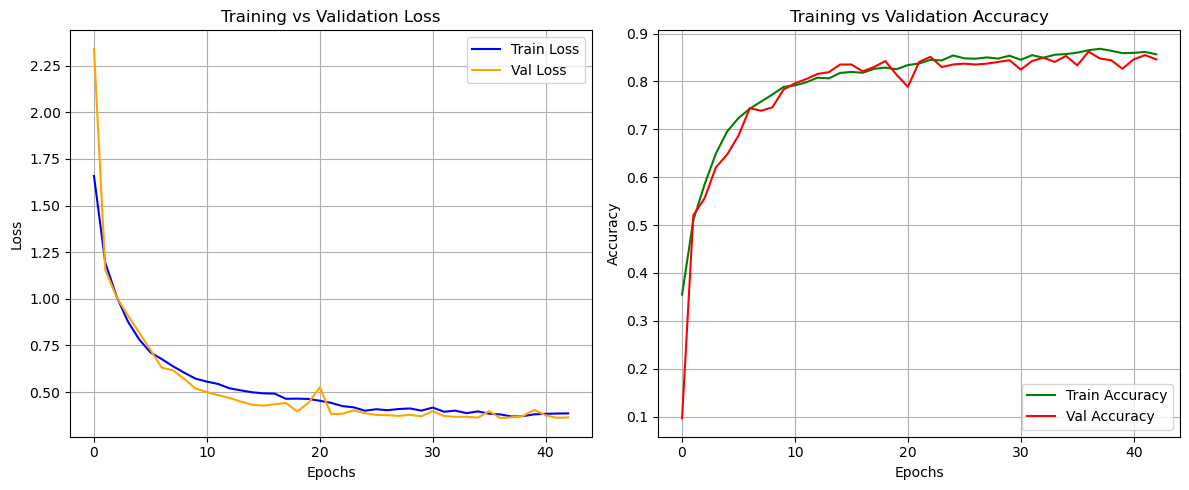

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
Test Accuracy: 0.8623
Test F1-score: 0.8581


In [118]:
from sklearn.metrics import accuracy_score, f1_score

# ===== TRAINING =====
history = enhanced_pipeline.train_enhanced_model(
    X_train=Xtrain,
    y_train=Ytrain,
    Xtest=Xtest,
    Ytest=Ytest,
    epochs=epochs,
    batch_size=batch_size,
    lr=learning_rate,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    patience_es=patience_es,
    patience_lr=patience_lr,
    min_delta=min_delta,
    checkpoint_path=checkpoint_path
)

# ===== PLOTS =====
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ===== TEST METRICS =====
y_pred_probs = enhanced_model.predict(Xtest)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Ytest, axis=1)

test_accuracy = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average='weighted')  # weighted for multi-class

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-score: {test_f1:.4f}")


In [119]:
# FLOPs counter for TF2 Keras models
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_flops(model: tf.keras.Model, batch_size: int = 1) -> int:
    """
    Returns the approximate number of floating-point operations (FLOPs)
    for a single forward pass of `batch_size` samples through `model`.
    Note: different profilers may count ops slightly differently.
    """
    # Make sure model is built (has defined input shape)
    if not model.built:
        # try to build with an example input
        input_shape = [batch_size] + list(model.input.shape[1:])
        model.build(input_shape)

    # Create a concrete function from the Keras model
    input_spec = tf.TensorSpec([batch_size] + list(model.input.shape[1:]), model.inputs[0].dtype)
    func = tf.function(lambda x: model(x))
    concrete_func = func.get_concrete_function(input_spec)

    # Convert to a frozen graph
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    # Import the graph_def into a new Graph and run the v1 profiler
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')

        with tf.compat.v1.Session(graph=graph) as sess:
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            # profile the graph to get float ops
            flops = tf.compat.v1.profiler.profile(
                graph=graph,
                run_meta=run_meta,
                cmd='op',
                options=opts
            )
            if flops is None:
                return 0
            return flops.total_float_ops

# Example usage:
# Assuming `model` is your Keras model (already created and compiled)
flops = get_flops(enhanced_model, batch_size=1)
print(f"FLOPs: {flops:,}  ({flops/1e9:.6f} GFLOPs) ")
print(f"Parameters: {enhanced_model.count_params():,}")


FLOPs: 2,418,579  (0.002419 GFLOPs) 
Parameters: 17,004


In [120]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np

# Predictions
y_pred_probs = enhanced_model.predict(Xtest)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Ytest, axis=1)

# Compute metrics
acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print("\nMODEL EVALUATION METRICS")
print("=" * 40)
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"Recall     : {recall:.4f}")
print(f"F1-score   : {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

MODEL EVALUATION METRICS
Accuracy   : 0.8623
Precision  : 0.8820
Recall     : 0.8623
F1-score   : 0.8581

Classification Report:
              precision    recall  f1-score   support

       16QAM       0.91      0.99      0.94        78
       64QAM       0.70      0.86      0.78        66
        BPSK       1.00      0.95      0.97        57
       CPFSK       0.90      1.00      0.95        76
        GFSK       0.57      0.67      0.61        69
        GMSK       1.00      0.48      0.65        73
       OTHER       1.00      1.00      1.00        51
        QPSK       0.98      0.97      0.97        89

    accuracy                           0.86       559
   macro avg       0.88      0.86      0.86       559
weighted avg       0.88      0.86      0.86       559

Confusion Matrix:
 [[77  0  0  1  0  0  0  0]
 [ 8 57  0  0  1  0  0  0]
 [ 0  0 54  1  0  0  0  2]
 [ 0  0  0 76  0  0  0  0]
 [ 0 23  0  0 46  0  0  0]
 [ 0  0  0  4 34 35  0  0

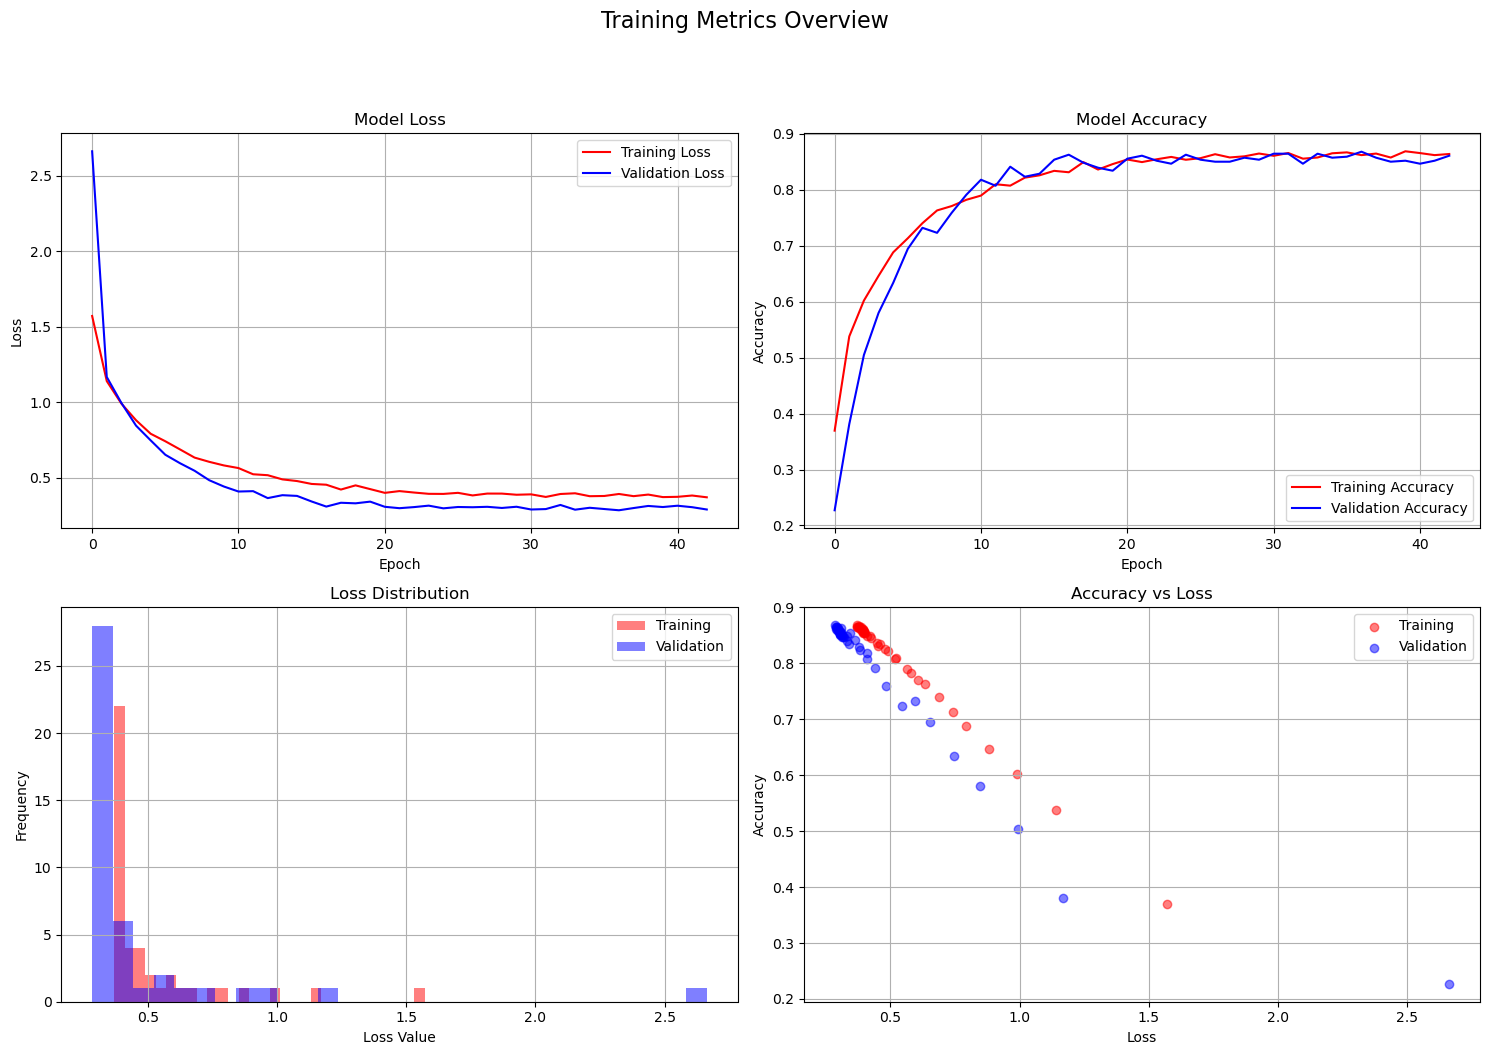


Final Training Metrics:
--------------------------------------------------
Final Training Loss: 0.3702
Final Validation Loss: 0.2894
Final Training Accuracy: 0.8635
Final Validation Accuracy: 0.8605

Model Improvement:
--------------------------------------------------
Loss Improvement: 1.2013
Accuracy Improvement: 0.4941


In [114]:
enhanced_history = history

def plot_training_metrics(history_dict):
    """
    Plot comprehensive training metrics including loss, accuracy, and learning rate
    """
    metrics = ['loss', 'accuracy']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Metrics Overview', fontsize=16, y=1.05)

    # Plot loss
    ax = axes[0, 0]
    ax.plot(history_dict['loss'], label='Training Loss', color='red')
    ax.plot(history_dict['val_loss'], label='Validation Loss', color='blue')
    ax.set_title('Model Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    ax.grid(True)

    # Plot accuracy
    ax = axes[0, 1]
    ax.plot(history_dict['accuracy'], label='Training Accuracy', color='red')
    ax.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='blue')
    ax.set_title('Model Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.grid(True)

    # Plot loss distribution
    ax = axes[1, 0]
    ax.hist(history_dict['loss'], bins=30, alpha=0.5, color='red', label='Training')
    ax.hist(history_dict['val_loss'], bins=30, alpha=0.5, color='blue', label='Validation')
    ax.set_title('Loss Distribution')
    ax.set_xlabel('Loss Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

    # Plot accuracy vs loss
    ax = axes[1, 1]
    ax.scatter(history_dict['loss'], history_dict['accuracy'],
              c='red', alpha=0.5, label='Training')
    ax.scatter(history_dict['val_loss'], history_dict['val_accuracy'],
              c='blue', alpha=0.5, label='Validation')
    ax.set_title('Accuracy vs Loss')
    ax.set_xlabel('Loss')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\nFinal Training Metrics:")
    print("-" * 50)
    print(f"Final Training Loss: {history_dict['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history_dict['val_loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {history_dict['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history_dict['val_accuracy'][-1]:.4f}")

    # Calculate improvement
    print("\nModel Improvement:")
    print("-" * 50)
    print(f"Loss Improvement: {history_dict['loss'][0] - history_dict['loss'][-1]:.4f}")
    print(f"Accuracy Improvement: {history_dict['accuracy'][-1] - history_dict['accuracy'][0]:.4f}")

# Use the function after training
plot_training_metrics(enhanced_history.history)

In [63]:
import pickle

# Define paths for saving
h5_model_path = r"C:\Users\USER\Documents\CNN\best_model_2.h5"
pickle_model_path = r"C:\Users\USER\Documents\CNN\best_model_2.pkl"

# Save as HDF5
enhanced_model.save(h5_model_path)
print(f"Model saved as HDF5 to {h5_model_path}")

# Save as Pickle
with open(pickle_model_path, 'wb') as f:
    pickle.dump(enhanced_model, f)
print(f"Model saved as Pickle to {pickle_model_path}")

Model saved as HDF5 to C:\Users\USER\Documents\CNN\best_model_2.h5
Model saved as Pickle to C:\Users\USER\Documents\CNN\best_model_2.pkl


🔍 COMPREHENSIVE TEST DATA EVALUATION
Using test data from: C:\Users\USER\Downloads\testing_data-20250817T073402Z-1-001\testing_data
🔄 Loading test data from separate test dataset...
Test data path: C:\Users\USER\Downloads\testing_data-20250817T073402Z-1-001\testing_data
📁 Found test classes: ['16QAM', '64QAM', 'BPSK', 'CPFSK', 'GFSK', 'GMSK', 'OTHER', 'QPSK']
  📊 16QAM: 125 samples
  📊 64QAM: 125 samples
  📊 BPSK: 125 samples
  📊 CPFSK: 125 samples
  📊 GFSK: 125 samples
  📊 GMSK: 125 samples
  📊 OTHER: 125 samples
  📊 QPSK: 125 samples

✅ Test data loaded successfully!
   • Total test samples: 1000
   • Input shape: (1000, 28, 28, 2)
   • Label shape: (1000, 8)
   • Number of classes: 8

Using optimized model for evaluation...

🔍 EVALUATING MODEL ON SEPARATE TEST DATASET
⏱️ Measuring inference performance...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

 OVERALL PERFORMANCE METRICS:
----------------------------------------
   • Test Accuracy: 0.8900 (89.00%)
   • Model Size: 0.09 MB
   • Tot

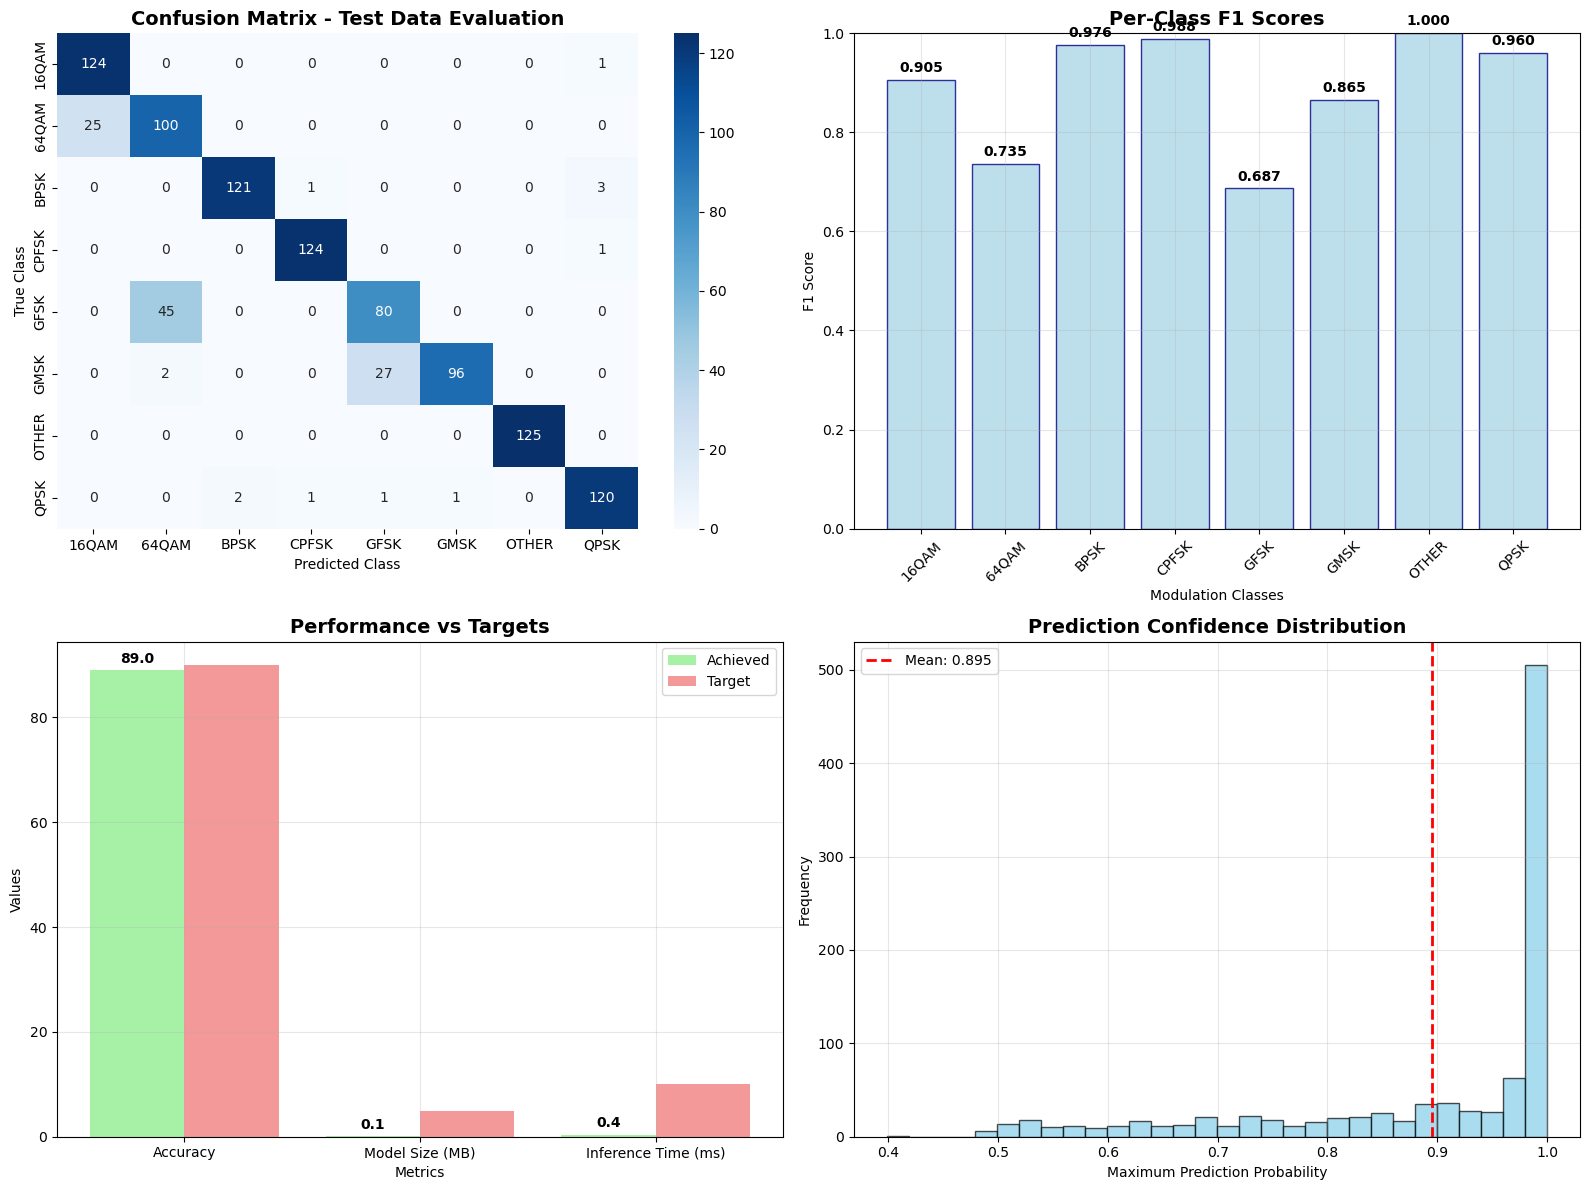


🎯 PERFORMANCE ANALYSIS & RECOMMENDATIONS
📈 TARGET ACHIEVEMENT STATUS:
----------------------------------------
   • Accuracy Target (≥90%): 89.00% - ⚠️ CLOSE
   • Model Size Target (≤5MB): 0.09MB - ✅ ACHIEVED
   • Speed Target (≤10ms): 0.42ms - ✅ ACHIEVED

 CLASS PERFORMANCE ANALYSIS:
----------------------------------------
   • Average F1 Score: 0.889 ± 0.112
   • Performance Range: 0.687 - 1.000
   • Classes needing attention: 64QAM, GFSK

 PREDICTION CONFIDENCE ANALYSIS:
----------------------------------------
   • Average Confidence: 0.895
   • Low Confidence Predictions (<0.8): 224/1000 (22.4%)

 RECOMMENDATIONS:
----------------------------------------
    TO IMPROVE ACCURACY:
     • Increase model capacity (alpha parameter)
     • Add more diverse data augmentation
     • Try ensemble methods
     • Fine-tune on problematic classes
    FOR POOR-PERFORMING CLASSES:
     • Apply class-specific data augmentation
     • Collect more samples for these classes
     • Use focal loss

In [115]:
class TestDataEvaluator:
    """
    Comprehensive evaluation using separate test dataset.
    Loads test data from the same folder structure as training data.
    """

    def __init__(self, test_data_path):
        self.test_data_path = test_data_path
        self.test_classes = None
        self.X_test = None
        self.y_test = None
        self.class_names = None

    def load_test_data(self):
        """Load test data from the specified path with same structure as training data."""
        print("🔄 Loading test data from separate test dataset...")
        print(f"Test data path: {self.test_data_path}")

        if not os.path.exists(self.test_data_path):
            print(f"❌ Test data path not found: {self.test_data_path}")
            return False

        # Get available classes from test data folders
        self.test_classes = [d for d in os.listdir(self.test_data_path)
                            if os.path.isdir(os.path.join(self.test_data_path, d))]
        self.test_classes.sort()  # Ensure consistent ordering

        print(f"📁 Found test classes: {self.test_classes}")

        samples = []
        labels = []
        sample_names = []
        class_distribution = {}

        for class_idx, class_name in enumerate(self.test_classes):
            class_path = os.path.join(self.test_data_path, class_name)
            npy_files = glob.glob(os.path.join(class_path, '*.npy'))

            class_samples = 0
            for npy_file in npy_files:
                try:
                    # Load I/Q samples
                    iq_samples = np.load(npy_file)

                    # Convert to real/imaginary format
                    real = np.real(iq_samples)
                    imag = np.imag(iq_samples)

                    # Interleave real and imaginary parts
                    iq_interleaved = np.ravel(np.column_stack((real, imag)))

                    # Take first 1568 samples (28x28x2 = 1568)
                    iq_trimmed = iq_interleaved[:1568]

                    # Reshape to (28, 28, 2)
                    iq_reshaped = iq_trimmed.reshape(28, 28, 2)

                    samples.append(iq_reshaped)

                    # Create one-hot label
                    label = np.zeros(len(self.test_classes))
                    label[class_idx] = 1.0
                    labels.append(label)

                    sample_names.append(os.path.basename(npy_file))
                    class_samples += 1

                except Exception as e:
                    print(f"⚠️ Error loading {npy_file}: {str(e)}")
                    continue

            class_distribution[class_name] = class_samples
            print(f"  📊 {class_name}: {class_samples} samples")

        self.X_test = np.array(samples, dtype=np.float32)
        self.y_test = np.array(labels, dtype=np.float32)
        self.class_names = self.test_classes

        print(f"\n✅ Test data loaded successfully!")
        print(f"   • Total test samples: {len(self.X_test)}")
        print(f"   • Input shape: {self.X_test.shape}")
        print(f"   • Label shape: {self.y_test.shape}")
        print(f"   • Number of classes: {len(self.test_classes)}")

        return True

    def evaluate_model(self, model, detailed_analysis=True):
        """
        Comprehensive model evaluation on test data.
        """
        if self.X_test is None:
            print("❌ No test data loaded. Please run load_test_data() first.")
            return None

        print("\n🔍 EVALUATING MODEL ON SEPARATE TEST DATASET")
        print("=" * 60)

        # Measure inference time
        print("⏱️ Measuring inference performance...")
        start_time = time.time()
        predictions = model.predict(self.X_test, verbose=1)
        total_inference_time = time.time() - start_time
        avg_inference_time_ms = (total_inference_time / len(self.X_test)) * 1000

        # Calculate predictions and ground truth
        y_pred = np.argmax(predictions, axis=1)
        y_true = np.argmax(self.y_test, axis=1)

        # Overall accuracy
        accuracy = np.mean(y_pred == y_true)

        # Model size
        model_size_mb = (model.count_params() * 4) / (1024 * 1024)

        print(f"\n OVERALL PERFORMANCE METRICS:")
        print("-" * 40)
        print(f"   • Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"   • Model Size: {model_size_mb:.2f} MB")
        print(f"   • Total Inference Time: {total_inference_time:.2f} seconds")
        print(f"   • Average Inference Time: {avg_inference_time_ms:.2f} ms per sample")
        print(f"   • Throughput: {len(self.X_test)/total_inference_time:.1f} samples/second")
        print(f"   • Total Parameters: {model.count_params():,}")

        # Detailed per-class analysis
        if detailed_analysis:
            print(f"\n DETAILED CLASSIFICATION REPORT:")
            print("-" * 50)
            print(classification_report(y_true, y_pred, target_names=self.class_names, digits=4))

            # Per-class metrics
            precision, recall, f1, support = precision_recall_fscore_support(
                y_true, y_pred, average=None
            )

            print(f"\n PER-CLASS PERFORMANCE SUMMARY:")
            print("-" * 50)
            for i, class_name in enumerate(self.class_names):
                print(f"   {class_name:>8s}: Precision={precision[i]:.3f}, "
                      f"Recall={recall[i]:.3f}, F1={f1[i]:.3f}, Support={support[i]}")

            # Identify best and worst performing classes
            best_class_idx = np.argmax(f1)
            worst_class_idx = np.argmin(f1)

            print(f"\n Best Performing Class: {self.class_names[best_class_idx]} (F1={f1[best_class_idx]:.3f})")
            print(f" Needs Attention: {self.class_names[worst_class_idx]} (F1={f1[worst_class_idx]:.3f})")

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        results = {
            'accuracy': accuracy,
            'model_size_mb': model_size_mb,
            'inference_time_ms': avg_inference_time_ms,
            'total_inference_time': total_inference_time,
            'throughput': len(self.X_test)/total_inference_time,
            'confusion_matrix': cm,
            'predictions': predictions,
            'y_true': y_true,
            'y_pred': y_pred,
            'precision': precision if detailed_analysis else None,
            'recall': recall if detailed_analysis else None,
            'f1_score': f1 if detailed_analysis else None,
            'support': support if detailed_analysis else None,
            'class_names': self.class_names
        }

        return results

    def create_visualization(self, results, save_plots=True):
        """
        Create comprehensive visualizations of test results.
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Confusion Matrix
        sns.heatmap(results['confusion_matrix'],
                   xticklabels=results['class_names'],
                   yticklabels=results['class_names'],
                   annot=True, fmt='d',
                   cmap='Blues',
                   ax=axes[0,0])
        axes[0,0].set_title('Confusion Matrix - Test Data Evaluation', fontsize=14, fontweight='bold')
        axes[0,0].set_xlabel('Predicted Class')
        axes[0,0].set_ylabel('True Class')

        # 2. Per-class F1 Scores
        if results['f1_score'] is not None:
            bars = axes[0,1].bar(results['class_names'], results['f1_score'],
                               color='lightblue', alpha=0.8, edgecolor='navy')
            axes[0,1].set_title('Per-Class F1 Scores', fontsize=14, fontweight='bold')
            axes[0,1].set_xlabel('Modulation Classes')
            axes[0,1].set_ylabel('F1 Score')
            axes[0,1].set_ylim(0, 1)
            axes[0,1].tick_params(axis='x', rotation=45)
            axes[0,1].grid(True, alpha=0.3)

            # Add value labels on bars
            for bar, score in zip(bars, results['f1_score']):
                height = bar.get_height()
                axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

        # 3. Performance Metrics Comparison
        metrics = ['Accuracy', 'Model Size (MB)', 'Inference Time (ms)']
        values = [results['accuracy']*100, results['model_size_mb'], results['inference_time_ms']]
        targets = [90, 5, 10]  # Target values

        x_pos = np.arange(len(metrics))
        bars1 = axes[1,0].bar(x_pos - 0.2, values, 0.4, label='Achieved', color='lightgreen', alpha=0.8)
        bars2 = axes[1,0].bar(x_pos + 0.2, targets, 0.4, label='Target', color='lightcoral', alpha=0.8)

        axes[1,0].set_title('Performance vs Targets', fontsize=14, fontweight='bold')
        axes[1,0].set_xlabel('Metrics')
        axes[1,0].set_ylabel('Values')
        axes[1,0].set_xticks(x_pos)
        axes[1,0].set_xticklabels(metrics)
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # Add value labels
        for bar, value in zip(bars1, values):
            height = bar.get_height()
            axes[1,0].text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                          f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

        # 4. Prediction Confidence Distribution
        max_probs = np.max(results['predictions'], axis=1)
        axes[1,1].hist(max_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1,1].axvline(np.mean(max_probs), color='red', linestyle='--', linewidth=2,
                         label=f'Mean: {np.mean(max_probs):.3f}')
        axes[1,1].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('Maximum Prediction Probability')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_plots:
            plt.savefig('test_evaluation_results.png', dpi=300, bbox_inches='tight')
            print("📊 Visualization saved as 'test_evaluation_results.png'")

        plt.show()

        return fig

    def performance_analysis(self, results):
        """
        Provide detailed performance analysis and recommendations.
        """
        print("\n🎯 PERFORMANCE ANALYSIS & RECOMMENDATIONS")
        print("=" * 60)

        # Target achievement analysis
        accuracy_target = 0.90
        size_target = 5.0  # MB
        speed_target = 10.0  # ms

        print(f"📈 TARGET ACHIEVEMENT STATUS:")
        print("-" * 40)

        accuracy_status = "✅ ACHIEVED" if results['accuracy'] >= accuracy_target else "⚠️ CLOSE" if results['accuracy'] >= 0.85 else "❌ NEEDS IMPROVEMENT"
        size_status = "✅ ACHIEVED" if results['model_size_mb'] <= size_target else "❌ EXCEEDED"
        speed_status = "✅ ACHIEVED" if results['inference_time_ms'] <= speed_target else "❌ EXCEEDED"

        print(f"   • Accuracy Target (≥90%): {results['accuracy']*100:.2f}% - {accuracy_status}")
        print(f"   • Model Size Target (≤5MB): {results['model_size_mb']:.2f}MB - {size_status}")
        print(f"   • Speed Target (≤10ms): {results['inference_time_ms']:.2f}ms - {speed_status}")

        # Class-wise performance analysis
        if results['f1_score'] is not None:
            print(f"\n CLASS PERFORMANCE ANALYSIS:")
            print("-" * 40)

            avg_f1 = np.mean(results['f1_score'])
            std_f1 = np.std(results['f1_score'])

            print(f"   • Average F1 Score: {avg_f1:.3f} ± {std_f1:.3f}")
            print(f"   • Performance Range: {np.min(results['f1_score']):.3f} - {np.max(results['f1_score']):.3f}")

            # Identify problematic classes
            poor_classes = [results['class_names'][i] for i, f1 in enumerate(results['f1_score']) if f1 < 0.8]
            if poor_classes:
                print(f"   • Classes needing attention: {', '.join(poor_classes)}")
            else:
                print(f"   • All classes performing well (F1 > 0.8)")

        # Confidence analysis
        confidence_scores = np.max(results['predictions'], axis=1)
        low_confidence = np.sum(confidence_scores < 0.8)

        print(f"\n PREDICTION CONFIDENCE ANALYSIS:")
        print("-" * 40)
        print(f"   • Average Confidence: {np.mean(confidence_scores):.3f}")
        print(f"   • Low Confidence Predictions (<0.8): {low_confidence}/{len(confidence_scores)} ({low_confidence/len(confidence_scores)*100:.1f}%)")

        # Recommendations
        print(f"\n RECOMMENDATIONS:")
        print("-" * 40)

        if results['accuracy'] < 0.90:
            print("    TO IMPROVE ACCURACY:")
            print("     • Increase model capacity (alpha parameter)")
            print("     • Add more diverse data augmentation")
            print("     • Try ensemble methods")
            print("     • Fine-tune on problematic classes")

        if results['model_size_mb'] > 5.0:
            print("    TO REDUCE MODEL SIZE:")
            print("     • Reduce alpha parameter (width multiplier)")
            print("     • Apply model pruning")
            print("     • Use more aggressive quantization")

        if results['inference_time_ms'] > 10.0:
            print("    TO IMPROVE SPEED:")
            print("     • Reduce model complexity")
            print("     • Optimize batch size for your hardware")
            print("     • Consider TensorFlow Lite with quantization")

        if poor_classes:
            print("    FOR POOR-PERFORMING CLASSES:")
            print("     • Apply class-specific data augmentation")
            print("     • Collect more samples for these classes")
            print("     • Use focal loss or class weighting")

# Set up test data path (Update this to your actual test data path)
TEST_DATA_PATH = r"C:\Users\USER\Downloads\testing_data-20250817T073402Z-1-001\testing_data"

# Alternative paths if the above doesn't work
alternative_paths = [
    "/content/drive/MyDrive/rfsc-dataset/Dataset_Deep_Radio/Dataset_Deep_Radio/testing_data",
    "testing_data",  # If in current directory
    "./testing_data"
]

# Try to find the correct path
test_path_found = None
if os.path.exists(TEST_DATA_PATH):
    test_path_found = TEST_DATA_PATH
else:
    print(f"Primary test path not found: {TEST_DATA_PATH}")
    print("Trying alternative paths...")
    for alt_path in alternative_paths:
        if os.path.exists(alt_path):
            test_path_found = alt_path
            print(f"Found test data at: {alt_path}")
            break

if test_path_found:
    print(f"🔍 COMPREHENSIVE TEST DATA EVALUATION")
    print("=" * 60)
    print(f"Using test data from: {test_path_found}")

    # Initialize evaluator
    evaluator = TestDataEvaluator(test_path_found)

    # Load test data
    if evaluator.load_test_data():
        # Ensure model is available
        if 'enhanced_model' in globals():
            print(f"\nUsing optimized model for evaluation...")
            test_results = evaluator.evaluate_model(enhanced_model, detailed_analysis=True)
        elif 'enhanced_model' in globals():
            print(f"\nUsing Model 4 for evaluation...")
            test_results = evaluator.evaluate_model(enhanced_model, detailed_analysis=True)
        else:
            print(" No trained model found. Please train a model first.")
            test_results = None

        if test_results:
            # Create visualizations
            evaluator.create_visualization(test_results, save_plots=True)

            # Performance analysis
            evaluator.performance_analysis(test_results)

            # Summary
            print(f"\n🎉 TEST EVALUATION COMPLETE!")
            print("=" * 60)
            print(f" Evaluated on {len(evaluator.X_test)} test samples")
            print(f" Test accuracy: {test_results['accuracy']*100:.2f}%")
            print(f" Model size: {test_results['model_size_mb']:.2f} MB")
            print(f" Inference speed: {test_results['inference_time_ms']:.2f} ms/sample")
            print("=" * 60)

        else:
            print(" Test evaluation failed.")

    else:
        print(" Failed to load test data.")

else:
    print(" Test data path not found!")
